# PSF Check

In [1]:
from gammapy.cube import PSFMap
from gammapy.irf import EnergyDependentTablePSF

In [2]:
from pathlib import Path

from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.data import GTI, Observation, EventList
from gammapy.maps import MapAxis, WcsGeom, Map, MapCoord
from gammapy.maps.profile import ImageProfile, ImageProfileEstimator
from gammapy.irf import EnergyDispersion2D, PSF3D, EnergyDependentMultiGaussPSF, load_cta_irfs

from gammapy.cube import (
    MapDataset,
    MapDatasetEventSampler,
    MapDatasetMaker,
)


In [3]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import astropy.units as u


In [4]:
def get_filename_dataset(livetime):
    filename = f"data/dataset_{livetime.value:.0f}{livetime.unit}.fits.gz"
    return BASE_PATH / filename


def get_filename_events(filename_dataset, filename_model, obs_id):
    obs_id=int(obs_id)
    model_str = filename_model.name.replace(filename_model.suffix, "")
    filename_events = filename_dataset.name.replace("dataset", "events")
    filename_events = BASE_PATH / f"data/models/{model_str}/" / filename_events
    filename_events = filename_events.name.replace(".fits.gz", f"_{obs_id:04d}.fits.gz")
    path = BASE_PATH / f"data/models/{model_str}/" / filename_events
    return path


In [5]:
def gaussian(x, amp, wid, cen):
    return amp * np.exp(-(x-cen)**2 / (2*wid**2.))


In [6]:
BASE_PATH = Path("../make.py").parent

In [7]:
model = "point-pwlsimple"
filename_model = BASE_PATH / f"models/{model}.yaml"


In [8]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
POINTING = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
LIVETIME = 10 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True)
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(4, 4), binsz=0.01, frame="galactic", axes=[ENERGY_AXIS]
)


### Create the dataset

In [9]:
irfs = load_cta_irfs(IRF_FILE)

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
#    maker = MapDatasetMaker(selection=["exposure", "edisp"])
#    maker = MapDatasetMaker(selection=["exposure", "edisp", "background"])
maker = MapDatasetMaker(selection=["exposure"])
dataset = maker.run(empty, observation)

In [10]:
# print(dataset.models)
# a=dataset.npred()
# a.plot_interactive()

In [11]:
models = Models.read(filename_model)
dataset.models = models

In [12]:
print(models)
# print(dataset.npred())

Models

Component 0: SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 0.000e+00   nan            deg        nan       nan  False
    lat_0 0.000e+00   nan            deg -9.000e+01 9.000e+01  False
    index 2.000e+00   nan                       nan       nan  False
amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True

	




### Simulate the events

In [13]:
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)

In [14]:
# events.table

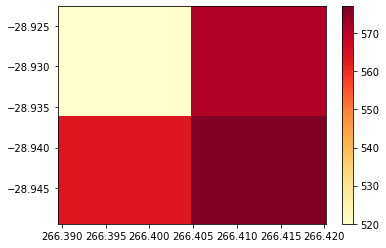

In [15]:
plt.hist2d(events.table['RA_TRUE'],events.table['DEC_TRUE'], bins=2, cmap=plt.cm.YlOrRd)
plt.colorbar()

### Pointlike source distribution

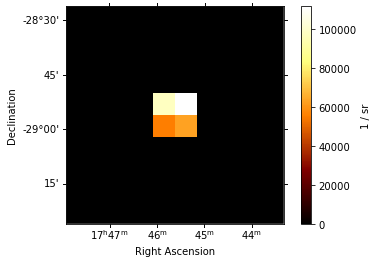

In [16]:
model = PointSpatialModel(lon_0="0.01deg", lat_0="0.01deg", frame="galactic",)

geom = WcsGeom.create(
    skydir=SkyCoord("0.0d 0.0d", frame="galactic"), width=(1, 1), binsz=0.1
)
model.plot(geom=geom, add_cbar=True)

### PSF test

##### Create a fake PSF

In [17]:
psf_gauss = EnergyDependentMultiGaussPSF.read(filename=IRF_FILE, hdu="POINT SPREAD FUNCTION")
# psf_gauss = EnergyDependentMultiGaussPSF(energy_lo=0.01*u.TeV, energy_hi=200*u.TeV, 
#                                          theta=[0, 2, 4, 6, 8] * u.deg, sigmas=[[0.1,0.1,0.1]]*u.deg,
#                                         norms=[1,1,1])

In [18]:
psf_gauss.sigmas[0] = (psf_gauss.sigmas[0] / psf_gauss.sigmas[0]) * 0.1

In [19]:
psf_gauss.norms[0] = np.where((psf_gauss.norms[0] != 0), 
                              ((psf_gauss.norms[0]/psf_gauss.norms[0]) * 1/(2*np.pi*0.1**2.)),
                             psf_gauss.norms[0])

/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [20]:
psf_3d = psf_gauss.to_psf3d(rad=np.linspace(0, 1, 100) * u.deg)

##### Create the dataset

In [21]:
irfs = load_cta_irfs(IRF_FILE)

irfs['psf'] = psf_3d

observation = Observation.create(
                                 obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
                                 )

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
#    maker = MapDatasetMaker(selection=["exposure", "edisp"])
#    maker = MapDatasetMaker(selection=["exposure", "edisp", "background"])
maker = MapDatasetMaker(selection=["exposure", "psf"])
dataset = maker.run(empty, observation)

##### Simulate the events

In [23]:
models = Models.read(filename_model)
dataset.models = models
sampler = MapDatasetEventSampler(random_state=0)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

events = sampler.run(dataset, observation)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x11627cbe0>)

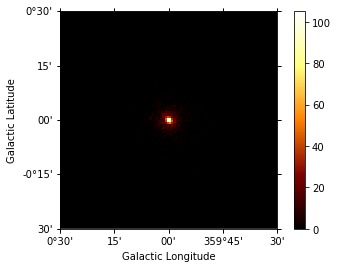

In [24]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.01, npix=(100, 100))
counts.fill_events(events)
counts.plot(add_cbar=True)

In [25]:
p = ImageProfileEstimator(axis='lon', method='sum')
profile = p.run(counts)

In [26]:
# gaussian(profile.table['x_ref'])
y = np.where(profile.table['profile']<=0, 1, profile.table['profile'])

In [27]:
# profile.table

In [28]:
init_vals = [800, 0.1, 0.0]

In [29]:
best_vals, covar = curve_fit(gaussian, profile.table['x_ref'], y, 
                             p0=init_vals, sigma=y**0.5)

print("############")
print(f"This is the normalization: {best_vals[0]}")
print(f"This is the sigma: {best_vals[1]}")
print(f"This is the center: {best_vals[2]}")
print("############")

############
This is the normalization: 242.76955863349406
This is the sigma: 0.03064977267290675
This is the center: -5.7584381821973295e-06
############


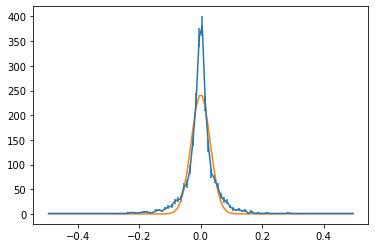

In [30]:
# smoothed = profile.smooth(kernel='gauss')
# smoothed.peek()
plt.errorbar(profile.table['x_ref'], y, yerr=y**0.5)
plt.plot(profile.table['x_ref'], gaussian(profile.table['x_ref'],*best_vals))
plt.show()

#### Comparing 1D histogram of the point-like model and simulated events

In [31]:
src_pos = SkyCoord(0.0*u.deg, 0.0*u.deg, frame='galactic')
evt_pos = SkyCoord(events.table['RA_TRUE'], events.table['DEC_TRUE'], frame='icrs')
sep = src_pos.separation(evt_pos).value

In [32]:
# c = MapCoord.create(evt_pos)
# print(c)

(array([ 46., 109., 184., 256., 335., 387., 400., 309., 156.,  50.]),
 array([5.50861784e-05, 1.45020155e-03, 2.84531692e-03, 4.24043229e-03,
        5.63554767e-03, 7.03066304e-03, 8.42577841e-03, 9.82089378e-03,
        1.12160092e-02, 1.26111245e-02, 1.40062399e-02]),
 <a list of 10 Patch objects>)

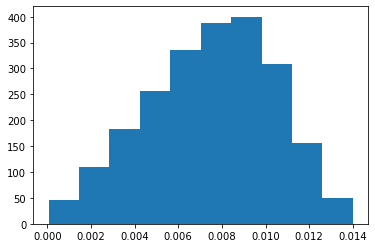

In [33]:
plt.hist(sep)

In [39]:
model = PointSpatialModel(lon_0="0.0deg", lat_0="0.0 deg", frame="galactic",)

bins=0.002
width=0.1
geom = WcsGeom.create(
    skydir=SkyCoord("0d 0d", frame="galactic"), width=(width, width), binsz=bins
)
# model.plot(geom=geom, add_cbar=True)

In [40]:
pnt_pos = geom.get_coord().skycoord

In [41]:
pnt_pos = np.reshape(pnt_pos, (1,int(width/bins)**2))[0]

In [42]:
pnt_sep = src_pos.separation(pnt_pos).value

(array([ 52., 120., 204., 264., 328., 428., 480., 372., 184.,  68.]),
 array([0.00141421, 0.00820244, 0.01499066, 0.02177889, 0.02856711,
        0.03535534, 0.04214356, 0.04893179, 0.05572001, 0.06250824,
        0.06929646]),
 <a list of 10 Patch objects>)

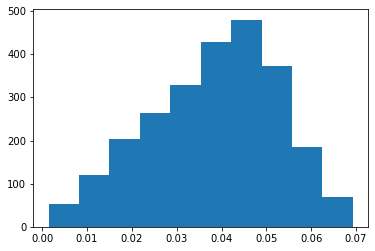

In [43]:
plt.hist(pnt_sep, bins=10)

(array([ 46., 109., 184., 256., 335., 387., 400., 309., 156.,  50.]),
 array([5.50861784e-05, 1.45020155e-03, 2.84531692e-03, 4.24043229e-03,
        5.63554767e-03, 7.03066304e-03, 8.42577841e-03, 9.82089378e-03,
        1.12160092e-02, 1.26111245e-02, 1.40062399e-02]),
 <a list of 10 Patch objects>)

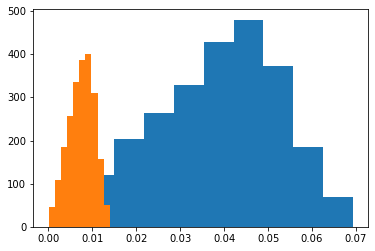

In [44]:
plt.hist(pnt_sep)
plt.hist(sep)